#### What is ground effect?

### Vortex Panel Method

In [1]:
import numpy
from matplotlib import pyplot, rcParams
from IPython.display import Image
%matplotlib inline
# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.family'] = 'StixGeneral'
rcParams['font.size'] = 12

In [2]:
# load panel's end points coordinates from file
x, y = numpy.loadtxt('resources/NACA0012_N=100', delimiter=' ', unpack=True)

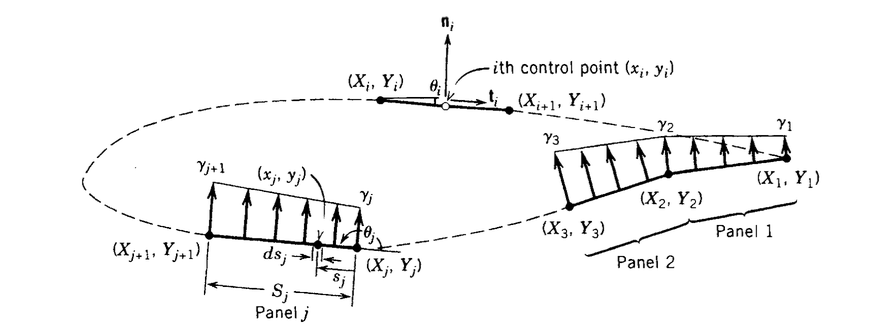

In [3]:
Image(filename='resources/panel.png')

image credit: Kuethe, Arnold M., and Chuen-Yen Chow. Foundations of Aerodynamics: Bases of Aerodynamics Design. Fifth Edition. Wiley, 1997, Page 156

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&- \sum_{j=1}^N \int_j \frac{\gamma_j(s_j)}{2\pi} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

In [4]:
# calculate the geometry parameters of panels
xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
np = len(xc)    # number of panels
l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis

In [5]:
def evaluate_coefficient(x, y, xc, yc, theta, l):
    """Given the end points' coordinates (x,y), angles(theta), panel length (l) of target panels, evaluate their contributions to source panels with control points (xc, yc), and return the panel-panel coefficient matrix in normal and tangential direction, and for the left end and right end respectively.
    
    Parameters:
    ----------
    x, y: (array of float)
          x,y coordinates of panels' end points
    xc, yc: (array of float)
            x,y coordinates of control points on panels
    theta: (array of float)
            array of angles between x-axis and panels
    l: (array of float)
        array of panels' length
        
    Returns:
    -------
    cn1: (array of float)
         the source panel's left end vortex's contribution on target panel in normal direction
    cn2: (array of float)
         the source panel's right end vortex's contribution on target panel in normal direction     
    ct1: (array of float)
         the source panel's left end vortex's contribution on target panel in tangential direction
    ct2: (array of float)
         the source panel's right end vortex's contribution on target panel in tangential direction
    """
    # initialize the coefficient matrix
    np = len(xc)
    cn1 = numpy.zeros((np,np), dtype=float)
    cn2 = numpy.zeros((np,np), dtype=float)
    ct1 = numpy.zeros((np,np), dtype=float)
    ct2 = numpy.zeros((np,np), dtype=float)
    # fill in the matrix when i=j (singularity)
    numpy.fill_diagonal(cn1, -1.)
    numpy.fill_diagonal(cn2, 1.)
    numpy.fill_diagonal(ct1, numpy.pi/2)
    numpy.fill_diagonal(ct2, numpy.pi/2)
    # double loop in i,j to evaluate j's contribution to i's panel when i!=j
    for i in range(np):
        for j in range(i)+range(i+1,np):
            A = -(xc[i]-x[j])*numpy.cos(theta[j])-(yc[i]-y[j])*numpy.sin(theta[j])
            B = (xc[i]-x[j])**2+(yc[i]-y[j])**2
            C = numpy.sin(theta[i]-theta[j])
            D = numpy.cos(theta[i]-theta[j])
            E = (xc[i]-x[j])*numpy.sin(theta[j])-(yc[i]-y[j])*numpy.cos(theta[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x[j])*numpy.sin(theta[i]-2*theta[j])+(yc[i]-y[j])*numpy.cos(theta[i]-2*theta[j])
            Q = (xc[i]-x[j])*numpy.cos(theta[i]-2*theta[j])-(yc[i]-y[j])*numpy.sin(theta[i]-2*theta[j])
            cn2[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1[i,j]=0.5*D*F+C*G-cn2[i,j]
            ct2[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1[i,j]=0.5*C*F-D*G-ct2[i,j]
    return cn1, cn2, ct1, ct2      

In [6]:
cn1, cn2, ct1, ct2 = evaluate_coefficient(x, y, xc, yc, theta, l)

In [7]:
def build_A(cn1, cn2, ct1, ct2):
    """Build the coefficient matrix of the linear system based on the panel-panel coefficient matrix
    
    Parameters:
    ----------
    cn1, cn2, ct1, ct2: see docstring in function 'evaluate_coefficient'
    
    Returns:
    -------
    an: (array of float)
        the coefficient matrix in normal direction, including the kutta-condition in the last row
    at: (array of float)
        the coefficient matrix in tangential direction
    """
    # initialize the coefficient matrix for normal and tangential directions
    np = cn1.shape[0]
    an = numpy.zeros((np+1,np+1),dtype=float)
    at = numpy.zeros((np,np+1),dtype=float)
    # loop in every element in the coefficient matrix
    for i in range(np):
        # fill the first column (0th-panel's first end's effect on ith-panel)
        # and the last column (-1th-panel's second end's effect on ith-panel)
        an[i,0] = cn1[i,0]
        an[i,-1] = cn2[i,-1]
        at[i,0] = ct1[i,0]
        at[i,-1] = ct2[i,-1]
        # each element in the middle are influenced by two panels
        # j-th panel's first end and (j-1)th panel's right end
        for j in range(1,np):
            an[i,j] = cn1[i,j] + cn2[i,j-1]
            at[i,j] = ct1[i,j] + ct2[i,j-1]
    # kutta condition
    an[-1,0] = 1.
    an[-1,-1] = 1.
    return an, at

In [8]:
an, at = build_A(cn1, cn2, ct1, ct2)

In [9]:
# freestream condition (unit freestream velocity)
alpha = 10.0    # aoa in degrees

In [10]:
# calculate the rhs
b = numpy.sin(theta-alpha/180.*numpy.pi)    # freestream's contribution
b = numpy.append(b, 0.)    # add kutta condition

In [11]:
gamma = numpy.linalg.solve(an, b)

In [12]:
# evaluate the tangential velocity and pressure coefficient at control points
vt = numpy.dot(at, gamma) + numpy.cos(theta-alpha/180.*numpy.pi)
cp = 1 - vt**2

In [13]:
def vortex_panel_method(filename, alpha):
    """Given the filename of panel coordinates file, and the angle of attack, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil
           
    """
    # load airfoil data
    x, y = numpy.loadtxt('resources/'+filename, delimiter=' ', unpack=True)
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    
    # evaluate the panel-to-panel coefficient 
    cn1, cn2, ct1, ct2 = evaluate_coefficient(x, y, xc, yc, theta, l)
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs
    b = numpy.sin(theta-alpha/180.*numpy.pi)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta-alpha/180.*numpy.pi)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta-alpha/180.*numpy.pi))
    
    return xc, cp, cl

#### With zeros angle of attack

In [14]:
xc_0, cp_0, cl_0 = vortex_panel_method('NACA0012_N=100', 0.0)

In [15]:
# load result from source vortex panel method with 100 panels
data = numpy.loadtxt('resources/data', delimiter=',')
xc_svpm, cp_svpm_0, cp_svpm_10 = data[0,:], data[1,:], data[2,:]

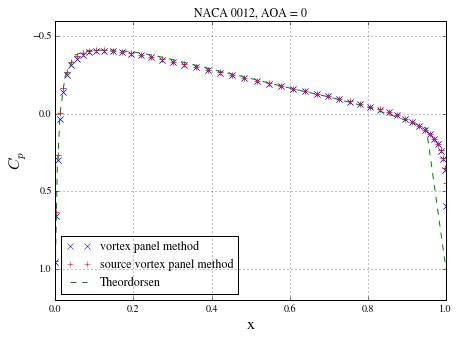

In [16]:
# plot the cp distribution and compare with Theordorsen solution
cp_theo = 1 - numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 0.956, 0.906, 0])
x_theo = numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])/100
pyplot.figure(figsize=(7,5))
l1, = pyplot.plot(xc_0, cp_0, 'bx', label='vortex panel method')
l2, = pyplot.plot(xc_svpm, cp_svpm_0, 'r+', label='source vortex panel method')
l3, = pyplot.plot(x_theo, cp_theo, 'g--', label='Theordorsen')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(handles=[l1,l2,l3], loc=3)
pyplot.grid('on')
pyplot.title('NACA 0012, AOA = 0')
pyplot.gca().invert_yaxis();

In [17]:
xc_10, cp_10, cl_10 = vortex_panel_method('NACA0012_N=100', 10.) 

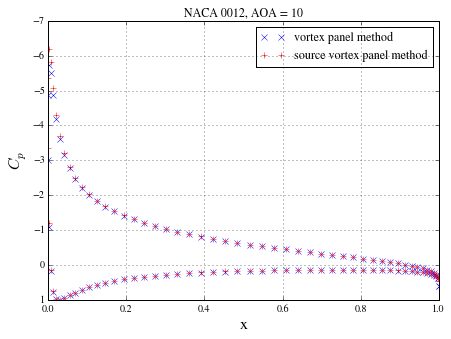

In [18]:
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
l1, = pyplot.plot(xc_10, cp_10, 'bx', label='vortex panel method')
l2, = pyplot.plot(xc_svpm, cp_svpm_10, 'r+', label='source vortex panel method')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(handles=[l1,l2], loc=1)
pyplot.grid('on')
pyplot.title('NACA 0012, AOA = 10')
pyplot.gca().invert_yaxis();

In [19]:
# compare the lift coefficient at aoa=10
print "angle of attack : 10 deg"
print "Cl using vortex panel method is %.3f." % cl_10
print "Cl using source vortex panel method is 1.209."

angle of attack : 10 deg
Cl using vortex panel method is 1.189.
Cl using source vortex panel method is 1.209.


### Vortex Panel Method + Method of Images

#### mirror the airfoil

In [20]:
x, y = numpy.loadtxt('resources/NACA0012_N=100', delimiter=' ', unpack=True)

In [21]:
h, alpha = 0.5, 10.0

In [22]:
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

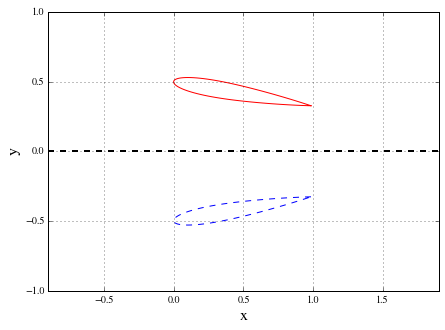

In [23]:
pyplot.figure(figsize=(7,5))
pyplot.plot(x,y, 'r-')
pyplot.plot(x_i, y_i, 'b--')
pyplot.axis('equal')
pyplot.grid('on')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.ylim(-1,1)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

In [24]:
# calculate the geometry parameters of panels
xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
np = len(xc)    # number of panels
l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
theta_i = -theta    # image panel's angle with x-axis

In [25]:
def evaluate_coefficient_image(x_i, y_i, xc, yc, theta_i, l):
    """Given the end points' coordinates (x,y), angles(theta), panel length (l) of target panels, evaluate their contributions to source panels with control points (xc, yc), and return the panel-panel coefficient matrix in normal and tangential direction, and for the left end and right end respectively.
    
    Parameters:
    ----------
    x_i, y_i: (array of float)
          x,y coordinates of image panels' end points
    xc, yc: (array of float)
            x,y coordinates of control points on main airfoil panels
    theta_i: (array of float)
            array of angles between x-axis and image panels
    l: (array of float)
        array of image panels' length
        
    Returns:
    -------
    cn1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in normal direction
    cn2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in normal direction     
    ct1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in tangential direction
    ct2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in tangential direction
    """
    np = len(xc)
    cn1_i = numpy.zeros((np,np), dtype=float)
    cn2_i = numpy.zeros((np,np), dtype=float)
    ct1_i = numpy.zeros((np,np), dtype=float)
    ct2_i = numpy.zeros((np,np), dtype=float)
    for i in range(np):
        for j in range(np):
            A = -(xc[i]-x_i[j])*numpy.cos(theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta_i[j])
            B = (xc[i]-x_i[j])**2+(yc[i]-y_i[j])**2
            C = numpy.sin(theta[i]-theta_i[j])
            D = numpy.cos(theta[i]-theta_i[j])
            E = (xc[i]-x_i[j])*numpy.sin(theta_i[j])-(yc[i]-y_i[j])*numpy.cos(theta_i[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x_i[j])*numpy.sin(theta[i]-2*theta_i[j])+(yc[i]-y_i[j])*numpy.cos(theta[i]-2*theta_i[j])
            Q = (xc[i]-x_i[j])*numpy.cos(theta[i]-2*theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta[i]-2*theta_i[j])
            cn2_i[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1_i[i,j]=0.5*D*F+C*G-cn2_i[i,j]
            ct2_i[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1_i[i,j]=0.5*C*F-D*G-ct2_i[i,j]
    return cn1_i, cn2_i, ct1_i, ct2_i

In [26]:
def ground_effect(filename, alpha, h):
    """Given the filename of panel coordinates file, and the angle of attack, and the height of the leading edge above the ground, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    h: (float)
        the height of the leading edge above the ground
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil under ground effect
           
    """
    # load airfoil data
    x, y = numpy.loadtxt('resources/'+filename, delimiter=' ', unpack=True)
    
    # rotate the coordinates
    x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
    y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
    x, y = x_rot, y_rot
    x_i, y_i = x_rot, -y_rot
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    theta_i = -theta
    
    # evaluate the panel-to-panel coefficient
    cn1_m, cn2_m, ct1_m, ct2_m = evaluate_coefficient(x, y, xc, yc, theta, l)
    cn1_i, cn2_i, ct1_i, ct2_i = evaluate_coefficient_image(x_i, y_i, xc, yc, theta_i, l)
    cn1, cn2, ct1, ct2 = cn1_m-cn1_i, cn2_m-cn2_i, ct1_m-ct1_i, ct2_m-ct2_i
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs (alpha is included in panel's geometry)
    b = numpy.sin(theta)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta))
    
    return xc, cp, cl

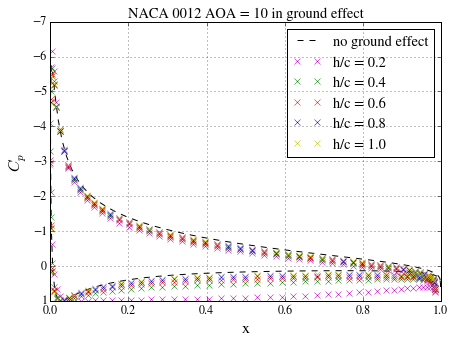

In [27]:
# run ground effect in a series of different height
alpha = 10.
n_set = 5
h_set = numpy.linspace(0.2, 1.0, n_set)
xc_set, cp_set, cl_set = [None]*n_set, [None]*n_set, [None]*n_set
for i,h in enumerate(h_set):
    xc_set[i], cp_set[i], cl_set[i] = ground_effect('NACA0012_N=100', alpha, h)

rcParams['font.size'] = 12
styles = ['mx','gx','rx','bx','yx']
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
pyplot.plot(xc_10, cp_10, 'k--', label='no ground effect')
for i,h in enumerate(h_set):
    pyplot.plot(xc_set[i], cp_set[i], styles[i], label='h/c = '+str(h))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(loc=1)
pyplot.grid('on')
pyplot.title('NACA 0012 AOA = 10 in ground effect')
pyplot.gca().invert_yaxis();

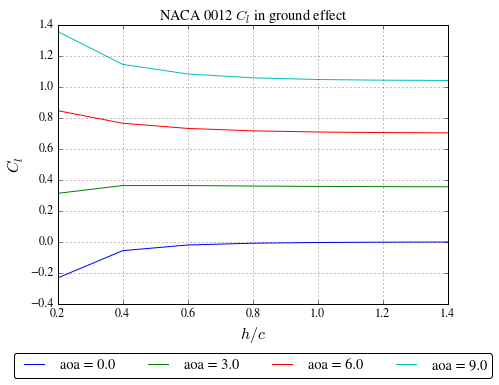

In [28]:
alpha_set = numpy.linspace(0., 9., 4)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect('NACA0012_N=100', alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label='aoa = '+str(alpha))
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title('NACA 0012 $C_l$ in ground effect')
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=len(alpha_set))
pyplot.show();

In [29]:
x, y = numpy.loadtxt('resources/NACA4412_N=100', delimiter=' ', unpack=True)

In [30]:
h, alpha = 0.5, 0.0
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

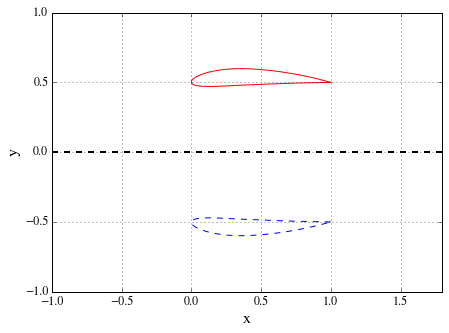

In [31]:
pyplot.figure(figsize=(7,5))
pyplot.plot(x,y, 'r-')
pyplot.plot(x_i, y_i, 'b--')
pyplot.axis('equal')
pyplot.grid('on')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.ylim(-1,1)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

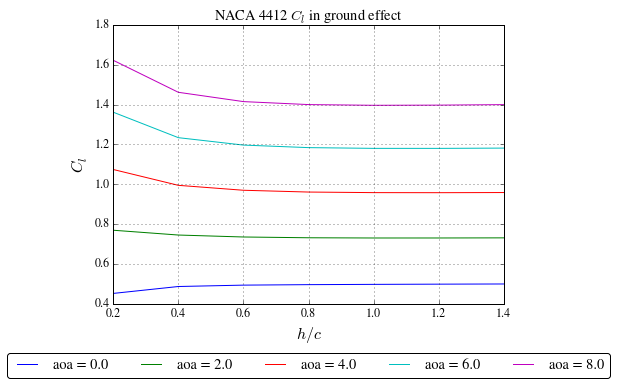

In [32]:
alpha_set = numpy.linspace(0., 8., 5)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect('NACA4412_N=100', alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label='aoa = '+str(alpha))
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title('NACA 4412 $C_l$ in ground effect')
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=len(alpha_set));

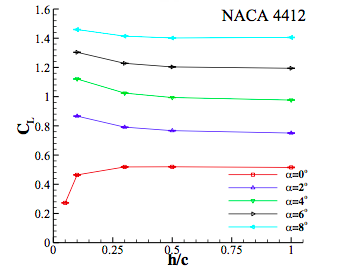

In [33]:
Image(filename='resources/NACA4412_cl.png')

Image credit: Fig.15, Implementation of a 2D Panel Method for Potential Flow Past Multi-Element Airfoil Configurations, by Diogo Chaves

#### Ground Effect for racecars

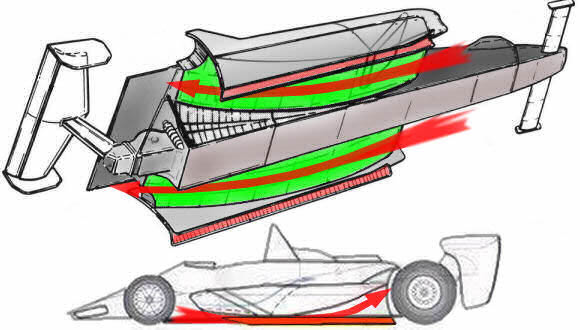

In [34]:
Image(filename='resources/lotus79.jpg')

Image credit: Lotus 79 http://www.formula1-dictionary.net/Images/ground_effect_lotus79b.jpg

In [35]:
x, y = numpy.loadtxt('resources/NACA4412_inv_N=100', delimiter=' ', unpack=True)

In [36]:
h, alpha = 0.5, -4.0

In [37]:
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

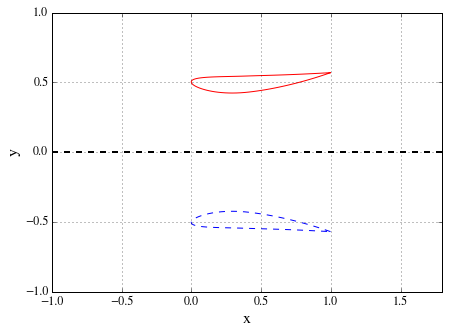

In [38]:
pyplot.figure(figsize=(7,5))
pyplot.plot(x,y, 'r-')
pyplot.plot(x_i, y_i, 'b--')
pyplot.axis('equal')
pyplot.grid('on')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.ylim(-1,1)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

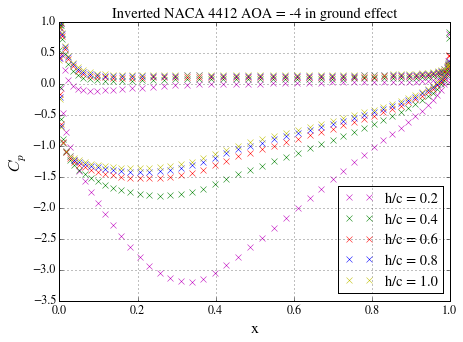

In [39]:
# run ground effect in a series of different height
alpha = -4.0
n_set = 5
h_set = numpy.linspace(0.2, 1.0, n_set)
xc_set, cp_set, cl_set = [None]*n_set, [None]*n_set, [None]*n_set
for i,h in enumerate(h_set):
    xc_set[i], cp_set[i], cl_set[i] = ground_effect('NACA4412_inv_N=100', alpha, h)

rcParams['font.size'] = 12
styles = ['mx','gx','rx','bx','yx']
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
for i,h in enumerate(h_set):
    pyplot.plot(xc_set[i], cp_set[i], styles[i], label='h/c = '+str(h))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(loc=4)
pyplot.grid('on')
pyplot.title('Inverted NACA 4412 AOA = -4 in ground effect')
pyplot.xlim(0.0, 1.0);

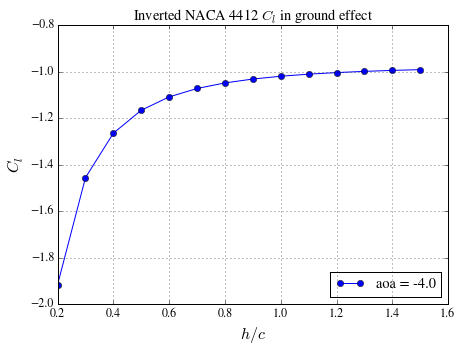

In [40]:
alpha = -4.0
h_set = numpy.linspace(0.2, 1.5, 14)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, h in enumerate(h_set):
    cl_set[i] = ground_effect('NACA4412_inv_N=100', alpha, h)[-1]    
pyplot.plot(h_set, cl_set, label='aoa = '+str(alpha), marker='o')
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title('Inverted NACA 4412 $C_l$ in ground effect')
pyplot.grid('on')
pyplot.legend(loc=4);

#### Reference

1. Kuethe, Arnold M., and Chuen-Yen Chow. Foundations of Aerodynamics: Bases of Aerodynamics Design. Fifth Edition. Wiley, 1997
2. Katz, Joseph, and Allen Plotkin. Low Speed Aerodynamics. Cambridge, UK: Cambridge UP, 2001
3. Chaves, Diogo. Implementation of a 2D Panel Method for Potential Flow Past Multi-Element Airfoil Configurations, Technical University of Lisbon, 2012

In [41]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/codefolding/main');

<IPython.core.display.Javascript object>